In [1]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [2]:
def generate_data(size: int, polynomial: list, params: dict) -> tuple:
    x = np.linspace(params['x-'], params['x+'], num=size)
    y = calc_poly(polynomial, x)
    y += np.random.normal(
        loc=params['m'],
        scale=params['sigma'],
        size=size
    )

    return x, y

def generate_errors(size: int, polynomial: list, params: dict) -> tuple:
    x = np.random.uniform(params['x-'], params['x+'], size=size)
    l, h = params['dist_errors']
    y = calc_poly(polynomial, x)
    y += np.random.uniform(l, h, size=size)
    
    return x, y

def calc_poly(poly: list, x: np.array) -> np.array:
    return sum([(x**deg)*coeff for deg, coeff in enumerate(poly[::-1])])


def make_line(params: dict, gen_params: dict) -> np.array:
    p = params['p']
    num = params['n']
    poly = params['poly_coeffs']

    x, y = generate_data(int(num*p), poly, gen_params)
    err_x, err_y = generate_errors(num - int(num*p), poly, gen_params)

    return np.array([np.r_[x, err_x], np.r_[y, err_y]])


In [3]:
INPUT = {
    'p': 0.8,
    'n': 200,
    'poly_coeffs': [-4.0, 12.0, 2, -3] # poly type: y = a_1 + a_2 * x = b + k * x
}

MODELING_PARAMS = {
    'x-': -5.0,
    'x+': 5.0,
    'm': 0,
    'sigma': 20,
    'dist_errors': (-700.0, 700.0)
}

data = make_line(INPUT, MODELING_PARAMS)

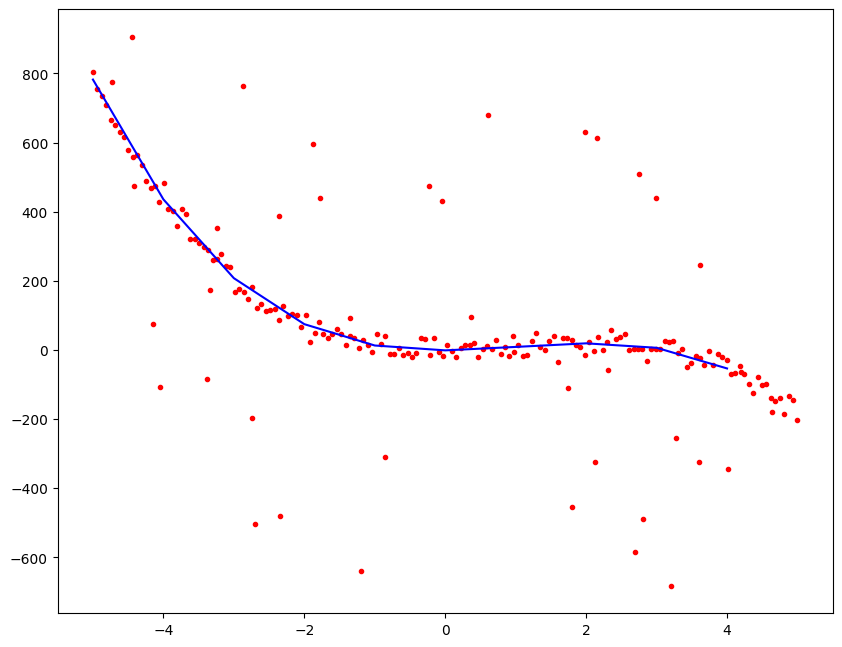

In [4]:
# Build RANSAC model with polynomial features
model = make_pipeline(
    PolynomialFeatures(len(INPUT['poly_coeffs'])-1),
    RANSACRegressor(random_state=0)
)

# Prepare data and fit into the model
x, y = data[0].reshape(-1, 1), data[1]
model.fit(x, y)

x_pred = np.arange(MODELING_PARAMS['x-'], MODELING_PARAMS['x+'])
y_pred = model.predict(x_pred.reshape(-1, 1))

# Plot approximate prediction
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(x.reshape(-1, 1), y, 'r.', x_pred, y_pred, 'b-')

In [5]:
# Extracting polynomial coeffs from the RANSAC model
est = model.steps[1][1].estimator_
model_coeffs = np.r_[est.coef_[:0:-1], est.intercept_]
print("Predicted coeffs of polynomial model:", model_coeffs)

# Compare coeffs with the input
for c_pred, c_true in zip(model_coeffs, INPUT["poly_coeffs"]):
    print(f"Coeff error between {c_true} and {c_pred} = {abs(c_true-c_pred)}")

Predicted coeffs of polynomial model: [-3.93945272 12.01637481  1.89218216 -1.1386803 ]
Coeff error between -4.0 and -3.9394527231596848 = 0.060547276840315245
Coeff error between 12.0 and 12.016374811385733 = 0.016374811385732713
Coeff error between 2 and 1.8921821588961647 = 0.1078178411038353
Coeff error between -3 and -1.138680300560523 = 1.861319699439477
